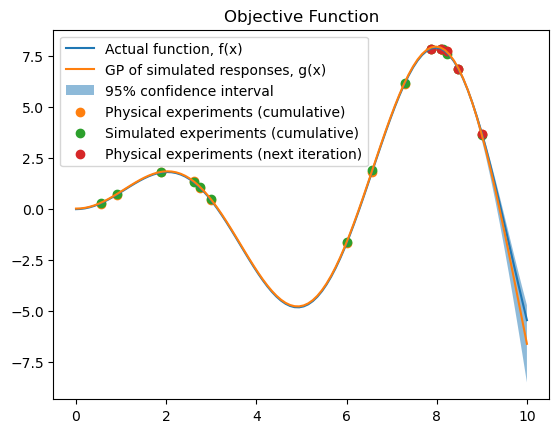

Iteration 1 complete


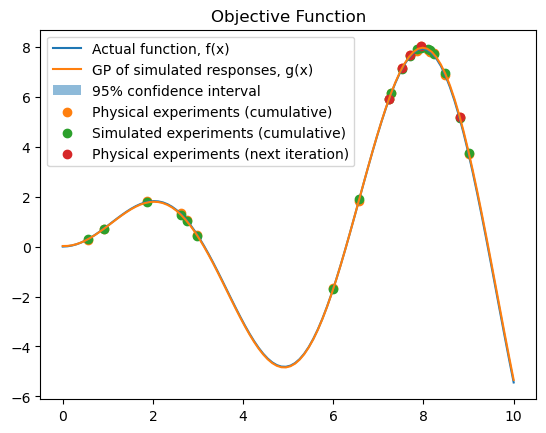

Iteration 2 complete
KeyboardInterrupt caught, calling on_optimization_end() to round things up


KeyboardInterrupt: 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C, WhiteKernel
from GPyOpt.methods import BayesianOptimization
import warnings

# Silence repetitive warnings
warnings.simplefilter('ignore')

# Random seed
np.random.seed(1)

# Define parameters
params = {
    'm': 5,
    'n': 100,
    'pretrain_n': 10,
    'percentile': 50,
    'iterations': 10,
    'laplace_alpha': 0.01,
    'degree': 2,
    'sim_stdev': 0.02,
    'max_bo_iter': 150,
    'random_seed': 2
}

# Objective function
def objective_function(x):
    return x * np.sin(x)  # Example function

# Error functions
r = np.random.default_rng(seed=params['random_seed'])
ran_err = lambda n, x: r.normal(0, x, n)
sim_err = lambda x, a, b: 0.1 * (a - 4) * x + 0.05 * (b + 3) * x**2 + r.normal(0, params['sim_stdev'])

# Simulation evaluation function
def sim_eval(x, a, b):
    return objective_function(x) + sim_err(x, a, b)

# Generate initial physical experiments
def generate_initial_experiments(x_range, n):
    df = pd.DataFrame(r.uniform(x_range[0], x_range[1], size=(n, 1)), columns=["x"])
    df["z"] = objective_function(df["x"]) + ran_err(n, 0.05)
    return df

# Bayesian optimization to calibrate simulation model
def calibrate_simulation_model(df, max_bo_iter):
    def sim_all(x):
        df["a"] = x[0, 0]
        df["b"] = x[0, 1]
        df["sim_z"] = sim_eval(df["x"], df["a"], df["b"])
        df["diff"] = df["z"] - df["sim_z"]
        return (df["diff"]**2).sum()
    
    bo_domain = [{'name': 'a', 'type': 'continuous', 'domain': (2, 5)},
                 {'name': 'b', 'type': 'continuous', 'domain': (-4, -1)}]
    
    bo = BayesianOptimization(f=sim_all, domain=bo_domain)
    bo.run_optimization(max_iter=max_bo_iter)
    
    return bo.x_opt

# Train Gaussian Process model
def train_gp_model(df):
    kernel = C(1, (1e-3, 1e3)) * RBF(length_scale=1, length_scale_bounds=(1e-2, 1e2)) + WhiteKernel(noise_level=1, noise_level_bounds=(1e-10, 1e1))
    model = GaussianProcessRegressor(kernel=kernel, normalize_y=True, random_state=3)
    model.fit(df[["x"]], df["sim_z"])
    return model

# Metropolis-Hastings sampling
def metropolis_hastings_sampling(model, df, x_range, m):
    def p(x):
        v, s = model.predict(x.reshape(-1, 1), return_std=True)
        if x[0, 0] >= x_range[0] and x[0, 0] <= x_range[1]:
            return np.max([v[0] + 1.96 * s[0] - df["sim_z"].median(), 0])
        else:
            return 0

    def metropolis_step(x, sig):
        prop_x = x + r.normal(0, sig, size=x.shape)
        u = r.uniform(0, 1)
        if u < np.min([1.0, p(prop_x) / p(x)]):
            value = prop_x
        else:
            value = x
        return value

    def mh_sampler(sig, sample_size, burn_in, lag):
        x = np.array([[df["x"].loc[np.argmax(df["sim_z"])]]])
        for i in range(burn_in):
            x = metropolis_step(x, sig)
        output = x
        for i in range(sample_size - 1):
            for j in range(lag):
                x = metropolis_step(x, sig)
            output = np.vstack((output, x))
        return output

    X_mh = mh_sampler(5, m, 300, 30)
    temp_df = pd.DataFrame(X_mh, columns=["x"])
    temp_df["z"] = objective_function(temp_df["x"]) + ran_err(m, 0.05)
    temp_df["a"] = df["a"].iloc[0]
    temp_df["b"] = df["b"].iloc[0]
    temp_df["sim_z"] = sim_eval(temp_df["x"], temp_df["a"], temp_df["b"])
    temp_df["diff"] = temp_df["z"] - temp_df["sim_z"]

    return temp_df

# Visualization
def plot_results(X, Z, df, temp_df, model):
    mean, std = model.predict(X.reshape(-1, 1), return_std=True)
    plt.plot(X, Z, label="Actual function, f(x)")
    plt.plot(X, mean, label="GP of simulated responses, g(x)")
    plt.fill_between(X.ravel(), mean - 1.96 * std, mean + 1.96 * std, alpha=0.5, label="95% confidence interval")
    plt.scatter(df["x"], df["z"], label="Physical experiments (cumulative)")
    plt.scatter(df["x"], df["sim_z"], label="Simulated experiments (cumulative)")
    plt.scatter(temp_df["x"], temp_df["z"], label="Physical experiments (next iteration)")
    plt.legend()
    plt.title("Objective Function")
    plt.show()

# Main loop
def active_learning_loop(params):
    x_range = (0, 10)  # Example range
    X = np.linspace(*x_range, 100)
    Z = objective_function(X)

    df = generate_initial_experiments(x_range, params['pretrain_n'])

    for iteration in range(params['iterations']):
        bo_x_opt = calibrate_simulation_model(df, params['max_bo_iter'])
        df["a"], df["b"] = bo_x_opt

        model = train_gp_model(df)
        temp_df = metropolis_hastings_sampling(model, df, x_range, params['m'])
        df = pd.concat([df, temp_df], ignore_index=True)

        plot_results(X, Z, df, temp_df, model)
        print(f"Iteration {iteration + 1} complete")

    return df

df = active_learning_loop(params)
print(df)